In [1]:
from numpy.random import default_rng
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from scipy.stats import norm

In [2]:
rng = default_rng(seed=2024)

# create random x
x = rng.uniform(-1, 1, 100)
# create random y
y = x * 0.6 + rng.normal(0, 0.25, 100)
# create betas to compare
betas = np.linspace(0.4, 0.85, 10)

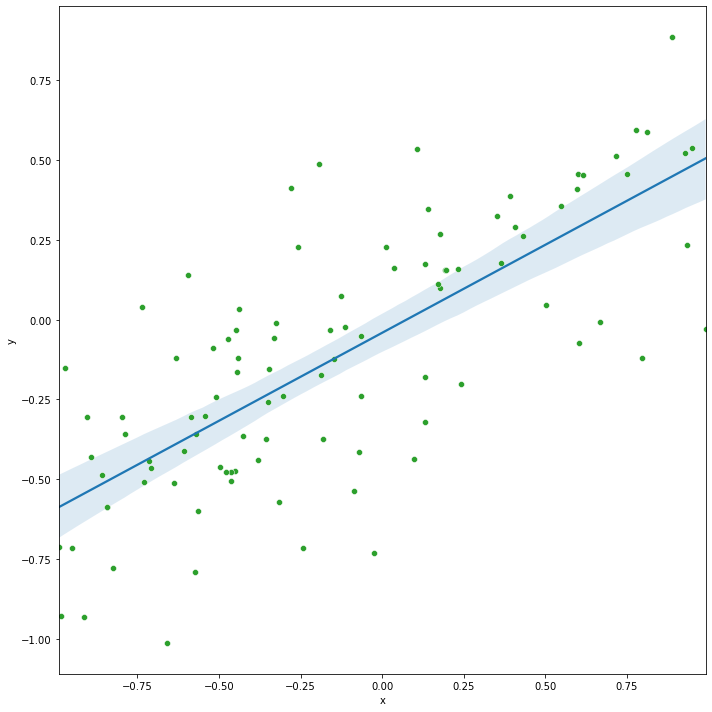

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=x, y=y, color='tab:blue', ax=ax, scatter_kws={'alpha': 0})
sns.scatterplot(x=x, y=y, ax=ax, color='tab:green')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()

In [4]:
X = add_constant(x)
OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     120.4
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           9.44e-19
Time:                        09:14:31   Log-Likelihood:                -10.230
No. Observations:                 100   AIC:                             24.46
Df Residuals:                      98   BIC:                             29.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0410      0.028     -1.462      0.147      -0.097       0.015
x1             0.5514      0.050     10.974      0.000       0.452       0.651
==============================================================================
Omnibus:                        0.649   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.723   Jarque-Bera (JB):                0.600
Skew:                          -0.185   Prob(JB):                        0.741
Kurtosis:                       2.912   Cond. No.                         1.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

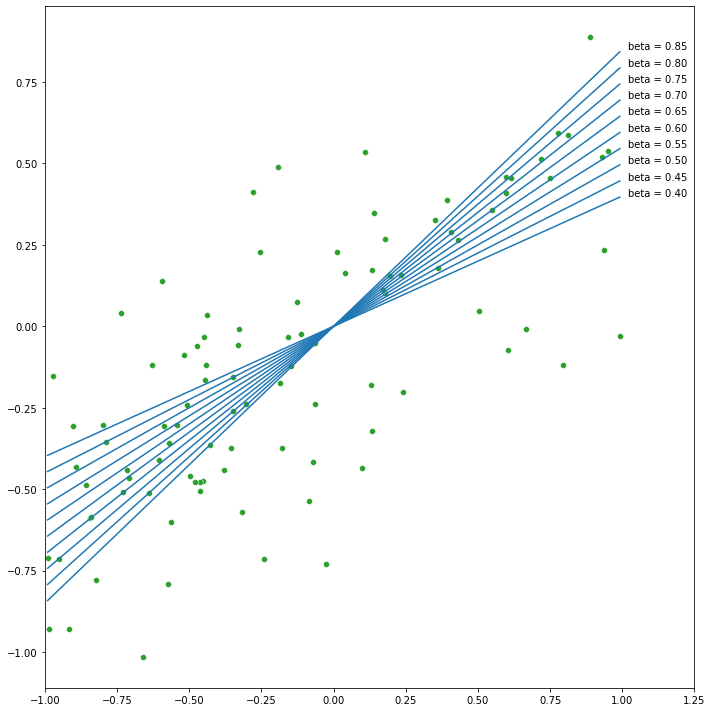

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
# plot the lines
for beta in betas:
    sns.lineplot(x=x, y=beta * x, ax=ax, color='tab:blue')
    ax.annotate(f"beta = {beta:.2f}", xy=(1, beta * 0.5), xytext=(1.02, beta))
sns.scatterplot(x=x, y=y, color='tab:green')
ax.set_xlim(-1, 1.25)
plt.tight_layout()

In [6]:
def likelihood(beta, x, y):
    return np.prod(norm(x * beta, 0.25).pdf(y))

In [7]:
likelihoods = np.array([likelihood(beta, x, y) for beta in betas])
norm_const = 1 / np.sum(likelihoods)
probabilities = likelihoods * norm_const

In [8]:
rng = default_rng(seed=20240316)

num_iterations = 1e4
positions = []
proposals = []
results = []

current = 8

for _ in range(int(num_iterations)):
    # record current position
    positions.append(current)
    # flip coin to generate proposal
    proposal = current + rng.choice([-1, 1])
    # now make sure he loops around the archipelago
    if proposal < 0:
        proposal = 9
    elif proposal > 9:
        proposal = 0
    proposals.append(proposal)
    # decide whether to accept proposal or not
    prob_move = likelihoods[proposal] / likelihoods[current]
    if rng.random() < prob_move:
        current = proposal
        results.append(True)
    else:
        current = current
        results.append(False)

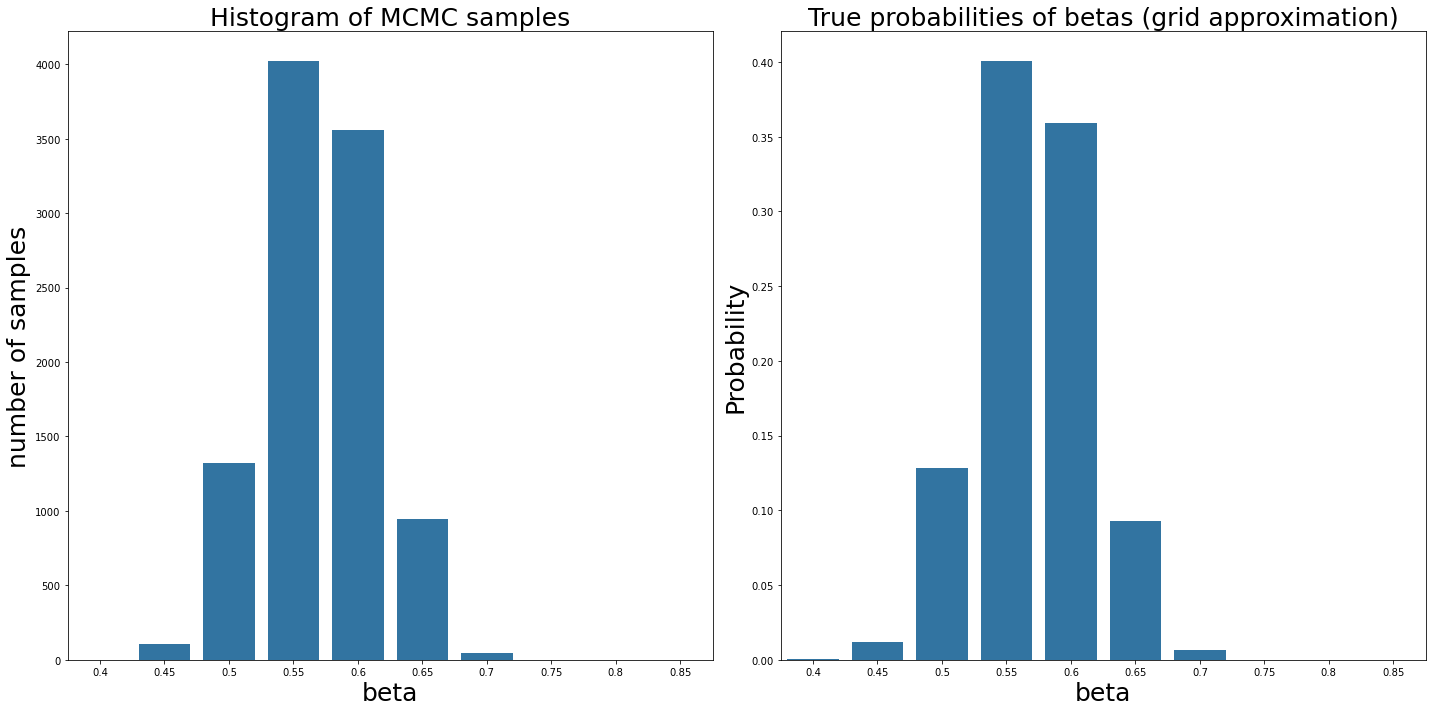

In [9]:
fig, ax = plt.subplots(figsize=(20, 10), ncols=2)
sns.barplot(x=betas, y=np.bincount(positions, minlength=10) , ax=ax[0], color='tab:blue')
ax[0].set_title('Histogram of MCMC samples', fontsize=25)
ax[0].set_xticks(range(10))
ax[0].set_xticklabels(betas)
ax[0].set_xlabel('beta', fontsize=25)
ax[0].set_ylabel('number of samples', fontsize=25)
sns.barplot(x=betas, y=probabilities, ax=ax[1], color='tab:blue')
ax[1].set_xlabel('beta', fontsize=25)
ax[1].set_ylabel('Probability', fontsize=25)
ax[1].set_title('True probabilities of betas (grid approximation)', fontsize=25)
plt.tight_layout()

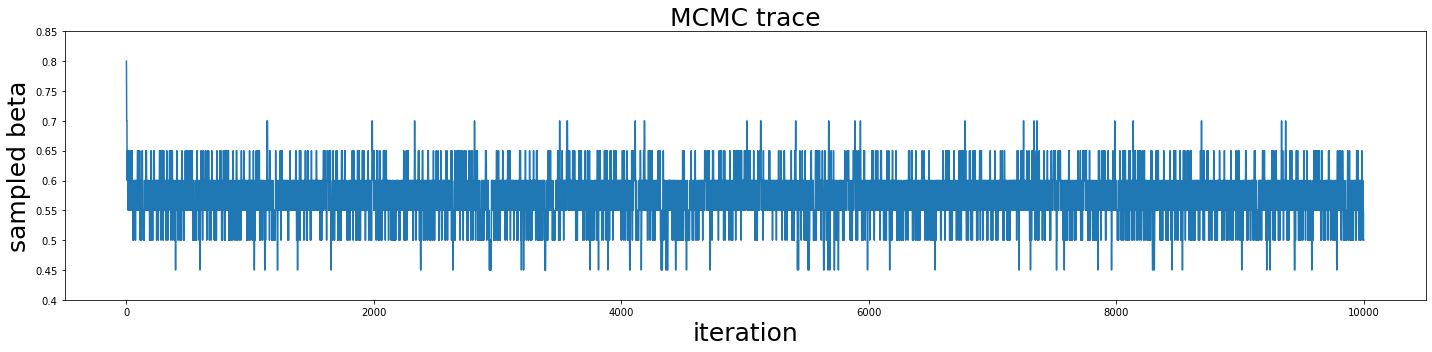

In [10]:
idx = 10000
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(range(idx), positions[:idx + 1], '-')
ax.set_yticks(range(10))
ax.set_yticklabels(betas)
ax.set_title('MCMC trace', fontsize=25)
ax.set_xlabel('iteration', fontsize=25)
ax.set_ylabel('sampled beta', fontsize=25)
plt.tight_layout()

In [11]:
for idx in range(100):
    fig, ax = plt.subplots(figsize=(30, 10), ncols=3)
    # plot the lines
    for beta in betas:
        if beta != betas[positions[idx]]:
            sns.lineplot(x=x, y=beta * x, ax=ax[0], color='tab:blue')
        else:
            sns.lineplot(x=x, y=beta * x, ax=ax[0], color='tab:orange')
    sns.scatterplot(x=x, y=y, color='tab:green', ax=ax[0])
    ax[0].set_xlim(-1.05, 1.05)
    # draw an arrow to the proposal
    if results[idx]:
        ax[0].annotate('', xy=(1, betas[proposals[idx]]), xytext=(1, betas[positions[idx]]), arrowprops=dict(facecolor='green', shrink=0.05))
    else:
        ax[0].annotate('', xy=(1, betas[proposals[idx]]), xytext=(1, betas[positions[idx]]), arrowprops=dict(facecolor='red', shrink=0.05))
    
    ax[1].plot(range(idx + 1), positions[:idx + 1], 'o-', markersize=20, lw=2)
    ax[1].set_xlim(0, 100)
    ax[1].set_ylim(-0.1, 10.1)
    ax[1].set_yticks(range(10))
    ax[1].set_yticklabels(betas)
    ax[1].set_title('MCMC trace', fontsize=40)
    ax[1].set_xlabel('iteration', fontsize=40)
    ax[1].set_ylabel('sampled beta', fontsize=40)

    sns.barplot(x=betas, y=np.bincount(positions[:idx+1], minlength=10), ax=ax[2], color='tab:blue')
    ax[2].set_title('Histogram of MCMC samples', fontsize=40)
    ax[2].set_xticks(range(10))
    ax[2].set_xticklabels(betas)
    ax[2].set_xlabel('beta', fontsize=40)
    ax[2].set_ylabel('number of samples', fontsize=40)

    plt.tight_layout()
    plt.savefig(f'lines_discrete/frame{idx:07d}.png')
    plt.close()

In [12]:
for idx in range(4):
    fig, ax = plt.subplots(figsize=(30, 10), ncols=3)
    # plot the lines
    for beta in betas:
        if beta != betas[positions[idx]]:
            sns.lineplot(x=x, y=beta * x, ax=ax[0], color='tab:blue')
        else:
            sns.lineplot(x=x, y=beta * x, ax=ax[0], color='tab:orange')
    sns.scatterplot(x=x, y=y, color='tab:green', ax=ax[0])
    ax[0].set_xlim(-1.05, 1.05)
    # draw an arrow to the proposal
    if results[idx]:
        ax[0].annotate('', xy=(1, betas[proposals[idx]]), xytext=(1, betas[positions[idx]]), arrowprops=dict(facecolor='green', shrink=0.05))
    else:
        ax[0].annotate('', xy=(1, betas[proposals[idx]]), xytext=(1, betas[positions[idx]]), arrowprops=dict(facecolor='red', shrink=0.05))
    
    ax[1].plot(range(idx + 1), positions[:idx + 1], 'o-', markersize=20, lw=2)
    ax[1].set_xlim(0, 10)
    ax[1].set_ylim(-0.1, 10.1)
    ax[1].set_yticks(range(10))
    ax[1].set_yticklabels(betas)
    ax[1].set_title('MCMC trace', fontsize=40)
    ax[1].set_xlabel('iteration', fontsize=40)
    ax[1].set_ylabel('sampled beta', fontsize=40)

    sns.barplot(x=betas, y=np.bincount(positions[:idx+1], minlength=10), ax=ax[2], color='tab:blue')
    ax[2].set_title('Histogram of MCMC samples', fontsize=40)
    ax[2].set_xticks(range(10))
    ax[2].set_xticklabels(betas)
    ax[2].set_xlabel('beta', fontsize=40)
    ax[2].set_ylabel('number of samples', fontsize=40)

    plt.tight_layout()
    plt.savefig(f'lines_discrete/extra_{idx:07d}.png')
    plt.close()